In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
import networkx as nx
import copy
import time
import orqviz

In [66]:
qubit_number = 8
qubits = range(qubit_number)

In [67]:
G=nx.complete_graph(qubit_number)

In [68]:
for node in range(qubit_number):
    G.add_node(node)
    
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7))

In [69]:
for node in range(qubit_number):
    if node<qubit_number-1: 
        G.add_edge(node,node+1)
len(G.edges)

28

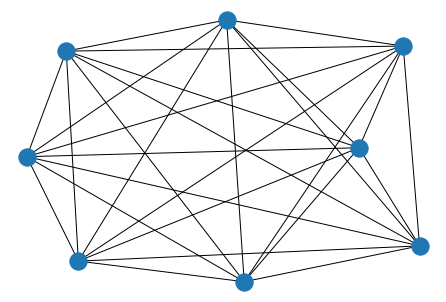

In [70]:
nx.draw(G)

In [71]:
def H_matrix(graph,edge_weights,no_of_qubits):
    # edge_weights= $\theta_1$ parameters for interaction terms
    # node_weights= $\theta_2$ parameters for single qubit terms
    
    full_matrix=np.zeros((2**no_of_qubits,2**no_of_qubits))
    
    # creating the two qubit interation terms:
    for i,edge in enumerate(graph.edges):
        
        zz_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only ZZ interaction 
                zz_int=np.kron(zz_int,qml.PauliZ.matrix)
                
            else:
                zz_int=np.kron(zz_int,np.identity(2))
                
        full_matrix+=edge_weights[i]*zz_int*(-1)
        
        
    for i,edge in enumerate(graph.edges):
        
        xx_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only XX interaction 
                xx_int=np.kron(xx_int,qml.PauliX.matrix)
                
            else:
                xx_int=np.kron(xx_int,np.identity(2))
                
        full_matrix+=edge_weights[i]*xx_int*(-1)
        
       
    for i,edge in enumerate(graph.edges):
        
        yy_int=1
        
        for qubit in range(no_of_qubits):
            
            if qubit in edge:
                # for only YY interaction 
                yy_int=np.kron(yy_int,qml.PauliY.matrix)
                
            else:
                yy_int=np.kron(yy_int,np.identity(2))
                
        full_matrix = full_matrix + edge_weights[i]*yy_int*(-1)
    
    return full_matrix

In [72]:
# generating gaussian numbers from box muller transformation

def generategaussian(n,var,mean):
    arr=[]
    
    u1=np.random.rand(n)
    u2=np.random.rand(n)
    arr.append(np.sqrt(var)*np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)+mean)
    arr.append(np.sqrt(var)*np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)+mean)
        
    return arr

In [73]:
Gaussians=generategaussian(10000,1,0)

In [74]:
from pylab import show,hist,subplot,figure

(array([[3.000e+00, 4.400e+01, 3.130e+02, 1.318e+03, 2.732e+03, 3.035e+03,
         1.847e+03, 5.880e+02, 1.190e+02, 1.000e+00],
        [3.000e+00, 4.000e+01, 2.930e+02, 1.232e+03, 2.788e+03, 3.115e+03,
         1.854e+03, 5.880e+02, 7.400e+01, 1.300e+01]]),
 array([-4.3068988 , -3.47778855, -2.6486783 , -1.81956805, -0.9904578 ,
        -0.16134755,  0.6677627 ,  1.49687295,  2.3259832 ,  3.15509345,
         3.98420371]),
 <a list of 2 BarContainer objects>)

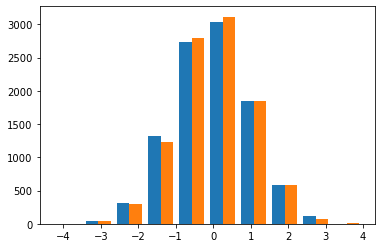

In [75]:
figure()
hist(Gaussians)

Defining the three variables except the interaction terms in the below cell

In [76]:
'''
Only the number of "runs" in the below cell should vary  
'''

'\nOnly the number of "runs" in the below cell should vary  \n'

In [77]:
run=1 # can be increased to have better results
# no transverse field in this model
mean=1  # mean value of the gaussian interactions Jij
var=np.linspace(0.8,1.8,7)  # variance of the gaussian interactions Jij
var=var[6:7]
var

array([1.8])

In [78]:
min_energy=[]
gaussian_arr=[]

start_time = time.time() 
for v in var:
    for i in range(run):
        edge_weights =generategaussian(len(G.edges),v,mean)[0]
        gaussian_arr.append(edge_weights)
        Ham=H_matrix(G,edge_weights,qubit_number)
        min_energy.append(np.real_if_close(min(np.linalg.eig(Ham)[0])))
print("Total elements",len(min_energy))
end_time = time.time()
print('Total time taken: ', (end_time-start_time)/60, ' mins.')

min_eng=[]
for j in range(len(var)):
    min_eng.append(np.sum(min_energy[run*j:run*(j+1)])/len(min_energy[run*j:run*(j+1)]))

print("The energy array->",(min_eng))


Total elements 1
Total time taken:  0.004043789704640707  mins.
The energy array-> [-35.69327873381342]


In [81]:
min_energy

[array(-35.69327873)]

Try couple of times to make the above plot as much as smooth, if that doesn't work try to increase the "run by 20" 

In [43]:
#####################################################

In [82]:
print(f"Minimum average eigen energies:{min_eng}")

Minimum average eigen energies:[-35.69327873381342]


In [83]:
dev = qml.device("lightning.qubit", wires= qubit_number) # 16 register qubits 

In [84]:
wires=list(range(qubit_number)) # will be used below
print("length of wires",len(wires))
for i in wires:
    print("wire->",i)
print("length of edges",len(G.edges))

length of wires 8
wire-> 0
wire-> 1
wire-> 2
wire-> 3
wire-> 4
wire-> 5
wire-> 6
wire-> 7
length of edges 28


In [85]:
[wires[0],wires[2]+1]

[0, 3]

In [86]:
'''
For a complete graph the below ansatz has to be defined separately
'''

'\nFor a complete graph the below ansatz has to be defined separately\n'

In [87]:
def SU4(l,wires=None):
    if len(l)!=15:
        raise ValueError('Incorrect parameters')
    
    
    else:
        qml.RZ(l[0],wires=wires[0])
        qml.RY(l[1],wires=wires[0])
        qml.RZ(l[2],wires=wires[0])
        qml.RZ(l[3],wires=wires[1])
        qml.RY(l[4],wires=wires[1])
        qml.RZ(l[5],wires=wires[1])
        qml.CNOT(wires=[wires[1],wires[0]])
        qml.RZ(l[6],wires=wires[0])
        qml.RY(l[7],wires=wires[1])
        qml.CNOT(wires=[wires[0],wires[1]])
        qml.RY(l[8],wires=wires[1])
        qml.CNOT(wires=[wires[1],wires[0]])
        qml.RZ(l[9],wires=wires[0])
        qml.RY(l[10],wires=wires[0])
        qml.RZ(l[11],wires=wires[0])
        qml.RZ(l[12],wires=wires[1])
        qml.RY(l[13],wires=wires[1])
        qml.RZ(l[14],wires=wires[1])

In [88]:
# Hardware efficient ansatz from paper "Certified variational quantum algorithms for eigenstate preparation"

def ansatz(l):
    
    if len(l)!=(qubit_number-1)*15:
        raise ValueError('Number of parameters are not correct!')
        
    else:
        
        for qubit in range(qubit_number-1):
            SU4(l[15*qubit:15*(1+qubit)],wires=[wires[qubit],wires[qubit+1]])
   # end...............................................


In [89]:
coeffs_toy = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
#qml.PauliZ(15)@qml.PauliZ(0),
obs_toy = [
    qml.PauliZ(0)@qml.PauliZ(1), qml.PauliZ(1)@qml.PauliZ(2), qml.PauliZ(2)@qml.PauliZ(3), qml.PauliZ(3)@qml.PauliZ(4),
     qml.PauliZ(4)@qml.PauliZ(5),qml.PauliZ(5)@qml.PauliZ(6),qml.PauliZ(6)@qml.PauliZ(7),qml.PauliZ(7)@qml.PauliZ(8),
    qml.PauliZ(8)@qml.PauliZ(9),qml.PauliZ(9)@qml.PauliZ(10),qml.PauliZ(10)@qml.PauliZ(11),qml.PauliZ(11)@qml.PauliZ(12),
    qml.PauliZ(12)@qml.PauliZ(13),qml.PauliZ(13)@qml.PauliZ(14),qml.PauliZ(14)@qml.PauliZ(15),
    qml.PauliX(0),qml.PauliX(1),qml.PauliX(2),qml.PauliX(3),qml.PauliX(4),qml.PauliX(5),qml.PauliX(6),qml.PauliX(7)
    ,qml.PauliX(8),qml.PauliX(9),qml.PauliX(10),qml.PauliX(11),qml.PauliX(12),qml.PauliX(13),qml.PauliX(14),qml.PauliX(15)

]
H_toy = qml.Hamiltonian(coeffs_toy, obs_toy)
print(H_toy)

  (-1) [X0]
+ (-1) [X1]
+ (-1) [X2]
+ (-1) [X3]
+ (-1) [X4]
+ (-1) [X5]
+ (-1) [X6]
+ (-1) [X7]
+ (-1) [X8]
+ (-1) [X9]
+ (-1) [X10]
+ (-1) [X11]
+ (-1) [X12]
+ (-1) [X13]
+ (-1) [X14]
+ (-1) [X15]
+ (-1) [Z0 Z1]
+ (-1) [Z1 Z2]
+ (-1) [Z2 Z3]
+ (-1) [Z3 Z4]
+ (-1) [Z4 Z5]
+ (-1) [Z5 Z6]
+ (-1) [Z6 Z7]
+ (-1) [Z7 Z8]
+ (-1) [Z8 Z9]
+ (-1) [Z9 Z10]
+ (-1) [Z10 Z11]
+ (-1) [Z11 Z12]
+ (-1) [Z12 Z13]
+ (-1) [Z13 Z14]
+ (-1) [Z14 Z15]


In [90]:
gaussian_arr[0]

array([-0.86680081,  1.37365421, -0.19918146,  2.67632182,  1.5739725 ,
       -0.39613194,  1.79789126, -0.03776871,  2.06843567,  2.72705371,
        1.43865108,  0.74414681,  2.59805083,  0.1499877 ,  0.77984357,
        4.26724454,  1.73527942, -1.60858426,  1.19590818,  2.10547687,
        4.32845696,  1.43918648, -0.54298868,  0.69418983,  3.41049945,
       -0.39263199,  1.81757603,  0.81553969])

In [91]:
coeffs_arr=[]
for v1,v in enumerate(var):
    for i in range(run):
        coeffs =np.concatenate([-gaussian_arr[i+run*v1] for k in range(3)]) # [-1,-1,-1,-1,-1,-g,-g,-g,-g,-g,-g]
        coeffs_arr.append(coeffs)
(coeffs_arr)[0]

array([ 0.86680081, -1.37365421,  0.19918146, -2.67632182, -1.5739725 ,
        0.39613194, -1.79789126,  0.03776871, -2.06843567, -2.72705371,
       -1.43865108, -0.74414681, -2.59805083, -0.1499877 , -0.77984357,
       -4.26724454, -1.73527942,  1.60858426, -1.19590818, -2.10547687,
       -4.32845696, -1.43918648,  0.54298868, -0.69418983, -3.41049945,
        0.39263199, -1.81757603, -0.81553969,  0.86680081, -1.37365421,
        0.19918146, -2.67632182, -1.5739725 ,  0.39613194, -1.79789126,
        0.03776871, -2.06843567, -2.72705371, -1.43865108, -0.74414681,
       -2.59805083, -0.1499877 , -0.77984357, -4.26724454, -1.73527942,
        1.60858426, -1.19590818, -2.10547687, -4.32845696, -1.43918648,
        0.54298868, -0.69418983, -3.41049945,  0.39263199, -1.81757603,
       -0.81553969,  0.86680081, -1.37365421,  0.19918146, -2.67632182,
       -1.5739725 ,  0.39613194, -1.79789126,  0.03776871, -2.06843567,
       -2.72705371, -1.43865108, -0.74414681, -2.59805083, -0.14

The printed values in the above cell will be -$J_{ij}$. As in the hamiltonian below there is a -ve sign before these coefficients

In [92]:
obs=[]
for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliZ(i)@qml.PauliZ(j))

print(obs)

[PauliZ(wires=[0]) @ PauliZ(wires=[1]), PauliZ(wires=[0]) @ PauliZ(wires=[2]), PauliZ(wires=[0]) @ PauliZ(wires=[3]), PauliZ(wires=[0]) @ PauliZ(wires=[4]), PauliZ(wires=[0]) @ PauliZ(wires=[5]), PauliZ(wires=[0]) @ PauliZ(wires=[6]), PauliZ(wires=[0]) @ PauliZ(wires=[7]), PauliZ(wires=[1]) @ PauliZ(wires=[2]), PauliZ(wires=[1]) @ PauliZ(wires=[3]), PauliZ(wires=[1]) @ PauliZ(wires=[4]), PauliZ(wires=[1]) @ PauliZ(wires=[5]), PauliZ(wires=[1]) @ PauliZ(wires=[6]), PauliZ(wires=[1]) @ PauliZ(wires=[7]), PauliZ(wires=[2]) @ PauliZ(wires=[3]), PauliZ(wires=[2]) @ PauliZ(wires=[4]), PauliZ(wires=[2]) @ PauliZ(wires=[5]), PauliZ(wires=[2]) @ PauliZ(wires=[6]), PauliZ(wires=[2]) @ PauliZ(wires=[7]), PauliZ(wires=[3]) @ PauliZ(wires=[4]), PauliZ(wires=[3]) @ PauliZ(wires=[5]), PauliZ(wires=[3]) @ PauliZ(wires=[6]), PauliZ(wires=[3]) @ PauliZ(wires=[7]), PauliZ(wires=[4]) @ PauliZ(wires=[5]), PauliZ(wires=[4]) @ PauliZ(wires=[6]), PauliZ(wires=[4]) @ PauliZ(wires=[7]), PauliZ(wires=[5]) @ Paul

In [93]:
H=[]

obs=[]
for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliZ(i)@qml.PauliZ(j))

for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliX(i)@qml.PauliX(j))

for i in range(qubit_number):
    for j in range(qubit_number):
        if i<j:
            obs.append(qml.PauliY(i)@qml.PauliY(j))
for v1 in range(len(var)):
    for i in range(run):
        H.append(qml.Hamiltonian(coeffs_arr[i+run*v1], obs))
print((H[0]))
print(len(H))

  (-4.328456955148246) [Z3 Z6]
+ (-4.328456955148246) [X3 X6]
+ (-4.328456955148246) [Y3 Y6]
+ (-4.267244541064653) [Z2 Z5]
+ (-4.267244541064653) [X2 X5]
+ (-4.267244541064653) [Y2 Y5]
+ (-3.4104994456843856) [Z4 Z7]
+ (-3.4104994456843856) [X4 X7]
+ (-3.4104994456843856) [Y4 Y7]
+ (-2.7270537077726633) [Z1 Z4]
+ (-2.7270537077726633) [X1 X4]
+ (-2.7270537077726633) [Y1 Y4]
+ (-2.6763218213109177) [Z0 Z4]
+ (-2.6763218213109177) [X0 X4]
+ (-2.6763218213109177) [Y0 Y4]
+ (-2.5980508286486383) [Z1 Z7]
+ (-2.5980508286486383) [X1 X7]
+ (-2.5980508286486383) [Y1 Y7]
+ (-2.105476874522461) [Z3 Z5]
+ (-2.105476874522461) [X3 X5]
+ (-2.105476874522461) [Y3 Y5]
+ (-2.068435669651498) [Z1 Z3]
+ (-2.068435669651498) [X1 X3]
+ (-2.068435669651498) [Y1 Y3]
+ (-1.817576027469596) [Z5 Z7]
+ (-1.817576027469596) [X5 X7]
+ (-1.817576027469596) [Y5 Y7]
+ (-1.7978912615544171) [Z0 Z7]
+ (-1.7978912615544171) [X0 X7]
+ (-1.7978912615544171) [Y0 Y7]
+ (-1.7352794157472693) [Z2 Z6]
+ (-1.7352794157472693)

In [94]:
G.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)])

In [95]:
specs_func = qml.specs(full_HVA_ansatz)
specs_func(params)

{'gate_sizes': defaultdict(int, {1: 105, 2: 21}),
 'gate_types': defaultdict(int, {'RZ': 63, 'RY': 42, 'CNOT': 21}),
 'num_operations': 126,
 'num_observables': 1,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 8,
 'depth': 77,
 'num_trainable_params': 105,
 'num_device_wires': 8,
 'device_name': 'lightning.qubit',
 'diff_method': 'parameter-shift'}

In [96]:
Trotter_steps=1 # Should remain 1

In [97]:
params=np.random.rand((qubit_number-1)*15*Trotter_steps)*0.1
len(params)

105

In [98]:
#@qml.qnode(dev)
def full_HVA_ansatz(params, **kwargs):
    
    for i in range(Trotter_steps):
        ansatz(params[int(len(params)/Trotter_steps)*i:int(len(params)/Trotter_steps)*(i+1)])
    
    #return qml.state()  

In [99]:
start_time = time.time()    
cost_fn_arr=[]
for v in range(len(var)):
    for i in range(run):
        cost_fn=qml.ExpvalCost(full_HVA_ansatz,H[i+run*v],dev)
        cost_fn_arr.append(cost_fn)
    
len(cost_fn_arr)
end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')

Time taken:  5.003611246744792e-05  mins.


In [36]:
# for testing purpose only and of no further use
start_time = time.time()    
cost_fn_val=[]
for v in range(len(var)):
    for i in range(run):
        cost_fn_val.append(cost_fn_arr[i+run*v](params))
    
len(cost_fn_val)
end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')

Time taken:  0.020374612013498942  mins.


In [33]:
#cost_fn=qml.ExpvalCost(full_HVA_2,H[0],dev)

In [100]:
par_arr=[]
costarr=[]
opt_val_arr=[]

In [101]:
start_time = time.time()    
for v1,v in enumerate(var):
    for i in range(run):
    #par_arr=[]
    #costarr=[]
        optimizer = qml.AdamOptimizer(stepsize=0.1)
        
        start_time2 = time.time()
        
        for j in range(0, 100+1):
            params, cost = optimizer.step_and_cost(cost_fn_arr[i+run*v1], params)

    # Prints the value of the cost function
            if j % 10 == 0:
                print(f"Cost at Step {j} of {i}th run for variance {v}: {cost}")
                
                end_time2 = time.time()
                print('Time taken at this step: ', (end_time2-start_time2)/60, ' mins.')
                
                costarr.append(cost)
                par_arr.append(params)
        opt_val_arr.append(cost)

end_time = time.time()
print('Total time taken: ', (end_time-start_time)/60, ' mins.')

Cost at Step 0 of 0th run for variance 1.8: -33.91738603368687
Time taken at this step:  0.43722474575042725  mins.
Cost at Step 10 of 0th run for variance 1.8: -34.25257951280447
Time taken at this step:  4.2909150918324785  mins.
Cost at Step 20 of 0th run for variance 1.8: -35.101452969279194
Time taken at this step:  8.274392743905386  mins.
Cost at Step 30 of 0th run for variance 1.8: -35.5224558873554
Time taken at this step:  12.722937941551208  mins.
Cost at Step 40 of 0th run for variance 1.8: -35.62128776921265
Time taken at this step:  17.521600985527037  mins.
Cost at Step 50 of 0th run for variance 1.8: -35.66412026191509
Time taken at this step:  23.452218274275463  mins.
Cost at Step 60 of 0th run for variance 1.8: -35.683019916135585
Time taken at this step:  31.241203900178274  mins.
Cost at Step 70 of 0th run for variance 1.8: -35.68780149100042
Time taken at this step:  57.06178207397461  mins.
Cost at Step 80 of 0th run for variance 1.8: -35.689876614885286
Time tak

In [ ]:
# calculate the Heissian too

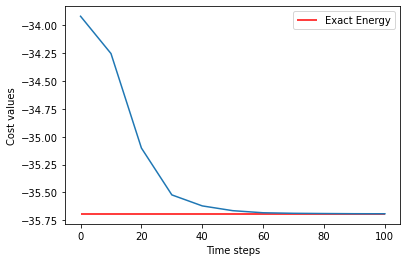

In [102]:
plt.plot(np.linspace(0,100,11),costarr)
plt.hlines(min_eng, 0, 100, color="red", label="Exact Energy")
plt.ylabel("Cost values")
plt.xlabel("Time steps")
plt.legend()
plt.show()

In [104]:
np.array(par_arr[10])

array([ 3.57804749e-02, -4.38642588e-01,  7.24396623e-01,  2.36621988e-02,
        8.12929802e-02,  3.14315161e-01,  7.45750784e-01,  1.38077460e-01,
       -1.28732372e-01,  8.56603038e-01,  1.86842072e-01,  7.74320546e-01,
        7.00383699e-01, -4.81571108e-01,  4.71501112e-01,  4.48626067e-01,
       -5.72294464e-01,  2.47467213e-01,  5.13834863e-02,  6.85309456e-02,
        7.99503307e-01,  1.68211826e-01,  7.71704219e-02, -8.13690004e-02,
        9.02557544e-01,  2.00181565e-01,  8.01276917e-01,  2.37413011e-01,
       -6.20232238e-01,  2.29897927e-01,  2.67187184e-01, -6.77855421e-01,
        2.72420000e-01,  7.64856708e-03, -2.91106277e-01,  2.65555412e-01,
        1.59178269e-01, -2.75378741e-02, -4.05804528e-02, -1.16635092e+00,
        2.83950952e-01, -3.24450978e-01,  8.08344763e-02, -6.19416361e-01,
        1.37382763e-01,  1.70947538e-01, -5.55116158e-01,  3.75969657e-01,
        2.82219621e-02,  1.02829686e-03,  1.24691224e+00,  2.82268358e-01,
        1.08594443e-04, -

In [105]:

final_param=np.array([ 3.57804749e-02, -4.38642588e-01,  7.24396623e-01,  2.36621988e-02,
        8.12929802e-02,  3.14315161e-01,  7.45750784e-01,  1.38077460e-01,
       -1.28732372e-01,  8.56603038e-01,  1.86842072e-01,  7.74320546e-01,
        7.00383699e-01, -4.81571108e-01,  4.71501112e-01,  4.48626067e-01,
       -5.72294464e-01,  2.47467213e-01,  5.13834863e-02,  6.85309456e-02,
        7.99503307e-01,  1.68211826e-01,  7.71704219e-02, -8.13690004e-02,
        9.02557544e-01,  2.00181565e-01,  8.01276917e-01,  2.37413011e-01,
       -6.20232238e-01,  2.29897927e-01,  2.67187184e-01, -6.77855421e-01,
        2.72420000e-01,  7.64856708e-03, -2.91106277e-01,  2.65555412e-01,
        1.59178269e-01, -2.75378741e-02, -4.05804528e-02, -1.16635092e+00,
        2.83950952e-01, -3.24450978e-01,  8.08344763e-02, -6.19416361e-01,
        1.37382763e-01,  1.70947538e-01, -5.55116158e-01,  3.75969657e-01,
        2.82219621e-02,  1.02829686e-03,  1.24691224e+00,  2.82268358e-01,
        1.08594443e-04, -7.40217336e-04, -2.26665574e+00,  2.06540201e-01,
        9.56522329e-01,  2.40341331e-01, -4.11123441e-01,  1.83902089e-01,
        2.23427998e-01, -3.92471829e-01,  2.28729342e-01,  5.99349972e-02,
        6.18422707e-02,  1.53026574e+00,  6.88508901e-01,  6.38555216e-02,
       -7.34801007e-02,  1.00390118e+00,  2.39293933e-01,  6.92531314e-01,
        1.68373940e-01, -3.87114466e-01,  5.50636030e-02,  4.43411366e-02,
       -3.58715500e-01, -4.89609256e-01,  9.12021595e-02, -2.96042785e-02,
        1.04806944e+00, -4.18065855e-01,  6.12640679e-02, -6.52131155e-02,
        9.46510894e-01,  2.05205869e-01,  9.97234258e-01, -3.81331940e-01,
       -3.57756868e-01, -6.26383008e-01, -6.19601889e-01, -3.97890836e-01,
       -7.26275587e-01,  3.65227487e-02, -3.43241670e-02,  5.10016556e-01,
       -7.53613005e-01,  4.58869118e-01, -4.88202203e-01,  2.13816060e-01,
        1.94664597e-01,  1.36925532e-01, -6.95655393e-01, -2.69647114e-01,
       -8.94195610e-01])

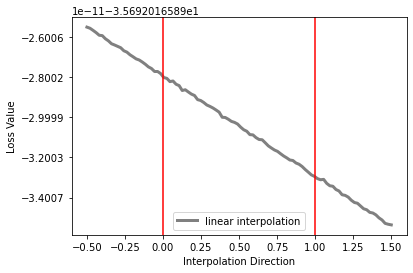

In [106]:
from orqviz.scans import perform_1D_interpolation, plot_1D_interpolation_result
end_points = (-0.5, 1.5)

interpolation_result = perform_1D_interpolation(params, final_param, 
                                                cost_fn, end_points=end_points)

plot_1D_interpolation_result(interpolation_result, label="linear interpolation", color="gray")

plt.legend()
plt.show()

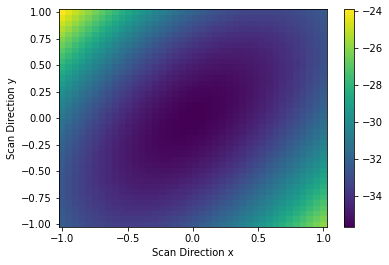

In [107]:
from orqviz.scans import perform_2D_scan, plot_2D_scan_result
from orqviz.geometric import (
    relative_periodic_wrap, 
    relative_periodic_trajectory_wrap, 
    get_random_normal_vector,
    get_random_orthonormal_vector,
)
dir1 = orqviz.geometric.get_random_normal_vector(len(params))
dir2 = orqviz.geometric.get_random_orthonormal_vector(dir1)

scan2D_result = orqviz.scans.perform_2D_scan(final_param, cost_fn,
                                direction_x=dir1, direction_y=dir2,
                                n_steps_x=40)
orqviz.scans.plot_2D_scan_result(scan2D_result)

In [108]:
from orqviz.pca import (get_pca, perform_2D_pca_scan, plot_pca_landscape, 
                        plot_optimization_trajectory_on_pca)

In [109]:
pca = get_pca(par_arr)
scan_pca_result = perform_2D_pca_scan(pca, cost_fn, n_steps_x=40)

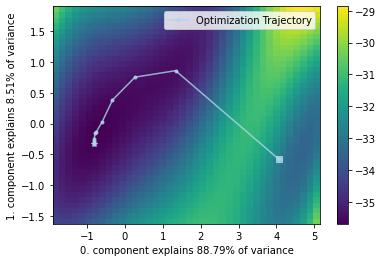

In [110]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(par_arr, pca, ax=ax, 
                                    label="Optimization Trajectory", color="lightblue")
plt.legend()
plt.show()

In [ ]:
scan_pca_result2 = perform_2D_pca_scan(pca, cost_fn, n_steps_x=80, offset=12)

In [ ]:
fig, ax = plt.subplots()
plot_pca_landscape(scan_pca_result2, pca, fig=fig, ax=ax)
plot_optimization_trajectory_on_pca(par_arr, pca, ax=ax)

In [54]:
from orqviz.hessians import get_Hessian

In [ ]:
start_time = time.time()    
hessian1 = get_Hessian(params=final_param, loss_function=cost_fn_arr[0], eps=1e-3)
end_time = time.time()
print('Time taken: ', (end_time-start_time)/60, ' mins.')